**Import Necessary Libraries**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import seaborn as sns
from PIL import Image
import numpy as np
import glob as gb
import keras
import time
import cv2
import os

**Import Dataset**

In [2]:
data_path = r"C:\Users\shakib\Downloads\Group_Dataset"

**Declare Variables**

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 2
categories = []
class_count = []

**Category and Barplot**

<AxesSubplot: >

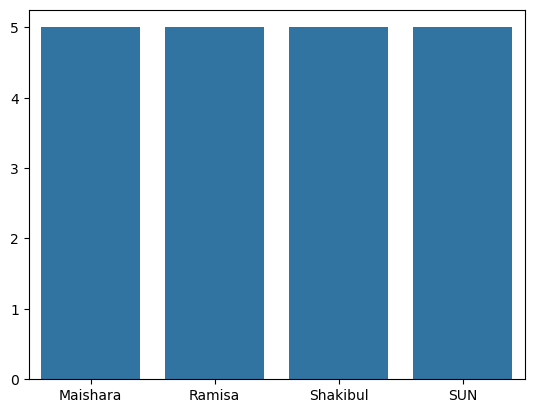

In [4]:
no_ofsamples = 0

for f in os.listdir(data_path):  
    files = gb.glob(pathname=str(data_path + '//' + f + '/*'))
    categories.append(f)
    class_count = len(files)
    no_ofsamples += len(files)

sns.barplot(x=categories, y=[len(gb.glob(pathname=str(data_path + '//' + f + '/*'))) for f in categories])

**Augmentation**

In [5]:
train_gen = ImageDataGenerator (
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    zoom_range = 0.3,
    brightness_range=[0.8, 1.2],
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2
)

**Training and Validation Batch**

In [6]:
train_batch = train_gen.flow_from_directory(
    directory = data_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset= 'training'
)

valid_batch =  train_gen.flow_from_directory(
    directory = data_path,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset= 'validation'
)

print(f"Training samples: {train_batch.samples}")
print(f"Validation samples: {valid_batch.samples}")

Found 12 images belonging to 4 classes.
Found 2 images belonging to 4 classes.
Training samples: 12
Validation samples: 2


**Test Batch Generation**

In [7]:
batch_x, batch_y = next(train_batch)
print(f"First training batch shape: {batch_x.shape}, Labels: {batch_y}")

batch_x_val, batch_y_val = next(valid_batch)
print(f"First validation batch shape: {batch_x_val.shape}, Labels: {batch_y_val}")

First training batch shape: (2, 224, 224, 3), Labels: [0. 2.]
First validation batch shape: (2, 224, 224, 3), Labels: [0. 3.]


**Transfer Learning**

In [8]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNet(input_shape=img_shape, include_top=False, weights='imagenet')

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

X = base_model(inputs, training=False)
X = tf.keras.layers.GlobalAveragePooling2D()(X)

X = tf.keras.layers.Dense(2048, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)  
X = tf.keras.layers.Dense(1024, activation='relu')(X)  
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)  
X = tf.keras.layers.Dropout(0.05)(X)

output = tf.keras.layers.Dense(4, activation='softmax')(X)  

model = tf.keras.Model(inputs, output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2099200   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

In [9]:
model.compile (
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy'])

In [10]:
h = model.fit(
    train_batch,  
    batch_size=BATCH_SIZE,
    epochs=10,
    steps_per_epoch=6, 
    validation_data=valid_batch,  
    validation_steps=1
)

Epoch 1/10
6/6 [==============================] - 12s 268ms/step - loss: 1.7925 - accuracy: 0.0000e+00 - val_loss: 1.1542 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 1s 130ms/step - loss: 1.3917 - accuracy: 0.2500 - val_loss: 1.1177 - val_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 1s 159ms/step - loss: 1.2212 - accuracy: 0.5833 - val_loss: 0.8944 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 1s 164ms/step - loss: 0.9979 - accuracy: 0.8333 - val_loss: 1.0587 - val_accuracy: 0.5000
Epoch 5/10
6/6 [==============================] - 1s 148ms/step - loss: 0.7722 - accuracy: 0.8333 - val_loss: 0.7374 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 1s 157ms/step - loss: 0.8398 - accuracy: 0.7500 - val_loss: 0.6192 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 139ms/step - loss: 0.7401 - accuracy: 0.6667 - val_loss: 0.5513 - val_accuracy: 1.0000
Epoch 8/10
6/6 

**Webcam Capture**

In [11]:
cap = cv2.VideoCapture(0)

print("Taking a picture in 5 seconds...")

time.sleep(5)
ret, frame = cap.read()

if not ret:
    print("Failed to capture image from webcam. Exiting...")
else:
    # Preprocess the frame (resize and normalize)
    img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=-1)
    student_name = categories[predicted_class[0]]
    
    cv2.putText(frame, f"Student: {student_name}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Captured Image - Prediction', frame)
    
    print(f"Predicted Student: {student_name}")
    
    cv2.waitKey(0)

cap.release()
cv2.destroyAllWindows()

Taking a picture in 5 seconds...
Predicted Student: SUN
